# Divergenceやmax_treeの状況を観察する


## ガウス分布（事前分布なし）
Divergenceや、max_tree_depth使い切りが発生する例

In [72]:

from stan_util import get_stan_model,print_code
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
def plot_rec(X,Y,data,NOF_PLOT=200):
    yy=data["yy"]
    if(len(yy)==0):
        print("NO-DATA")
        return
    skip=yy.shape[0]//NOF_PLOT
    if(skip<1):skip=1
    plt.title("Regression lines")
    plt.plot(X,yy[::skip,:].transpose(),color="blue",alpha=0.1)
    plt.plot(X,Y,color="red")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()
    plt.title("Residue of Y")
    plt.xlabel("X")
    plt.ylabel("Y-yy")
    plt.plot(X,yy[::skip,:].transpose()-Y.reshape(-1,1),color="blue",alpha=0.1)
    plt.show()

========1st: Without prior
1 
2 functions{
3     vector func(int N,vector x,real a,real b,real u,real s,real sigma){
4         vector[N] xx=(x-u)/s; return a*exp(-xx .* xx ) + b;
5     }
6 }
7 data{
8     int N;
9     vector[N] X;
10     vector[N] Y;
11 
12 
13 
14 
15 
16 }
17 
18 parameters{
19     real a;
20     real b;
21     real u;
22     real<lower=0,upper=1000> s;
23     real<lower=0> sigma;
24 }
25 transformed parameters{
26     vector[N] yy;
27     yy=func(N,X,a,b,u,s,sigma);
28 }
29 
30 model{
31     Y ~ normal(yy,sigma);
32 }
33 


Inference for Stan model: reg_27285fad7012e63ff2e41b392a754705.
16 chains, each with iter=1500; warmup=1000; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=8000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
s     314.18   85.78 331.39   0.87   0.97 205.91 597.18 956.71     15   1.48
u     1.7e12  1.4e12 1.3e13-9.5e12 -6.8e8  -0.03   0.03 4.0e13     83   1.22
a    -4.4e12  1.2e13 3.5e13-1.3e14 -1.3e8   4.76   5.19 6.6e13      9   4.95
b       0.99    0.23   0.67  -0.02   0.18   1.38   1.53   1.74      8   5.42
sigma   1.58    0.17   0.49   0.89   0.97   1.87   1.97   2.13      8    6.0

Samples were drawn using NUTS at Wed Sep 23 22:52:30 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


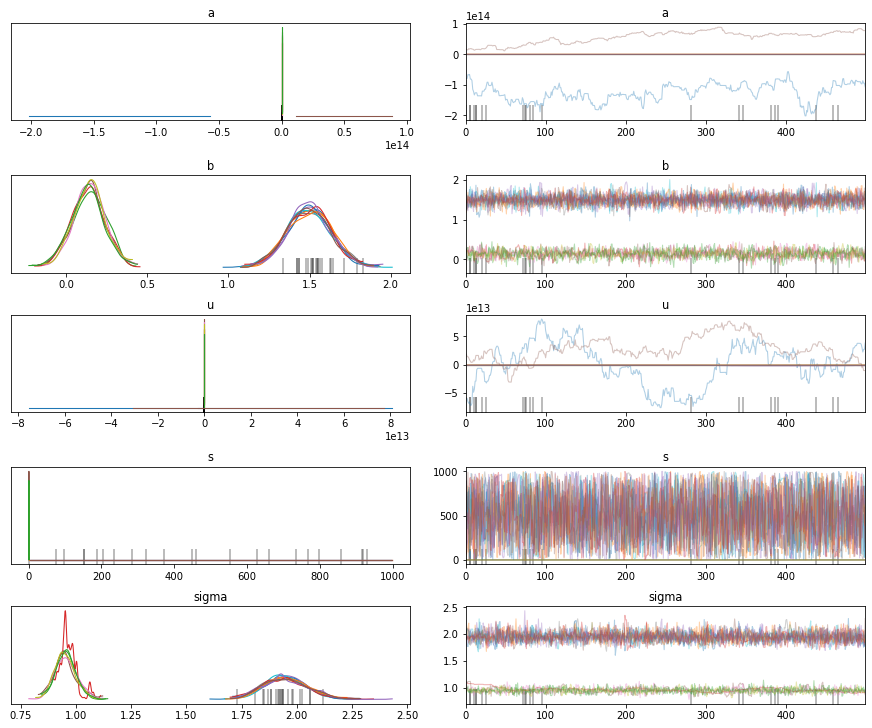

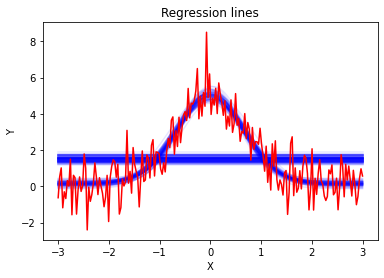

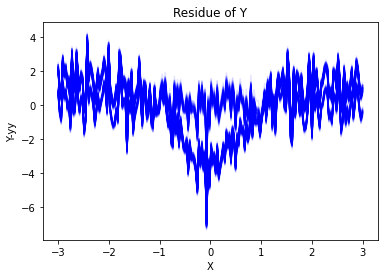

In [76]:


N=200
X=np.linspace(-3,3,N)
Y=np.random.randn(N)+ 5*np.exp(-X**2)

#make model
print("========1st: Without prior")
param=[{"name":"a","prio":"none","opt":""},
       {"name":"b","prio":"none","opt":""},
       {"name":"u","prio":"none","opt":""},
       {"name":"s","prio":"none","opt":"<lower=0,upper=1000>"}, #NaNよけのためにupper limitを設定している（アドホックな対処で、深い意味はない)
       {"name":"sigma","prio":"none","opt":"<lower=0>"},
       ]
d={"param":param,"func":"vector[N] xx=(x-u)/s; return a*exp(-xx .* xx ) + b;"} #回帰関数をガウス関数(exp(-x**2)として定義
model=get_stan_model("reg",d)
print_code(model)

#run stan code
stan_data={
        "N":N,
        "X":X,
        "Y":Y,
        }

fit=model.sampling(data=stan_data,warmup=1000,iter=1500,chains=16)

#visualize
print(fit.stansummary(pars=list(set(fit.model_pars)-set(["yy"]))))
az.plot_trace(fit, var_names=("a", "b","u","s","sigma"))
plt.show()
plot_rec(X,Y,fit.extract("yy"))


## Divergentおこしてる部分を可視化
変数単位で見るだけなら、上にあるようにtrace_plotに黒い印がでるのでそれで十分

そうではなくて、変数からグラフ書き起こしたい場合には以下の用な方法をとる

全然fitできないサンプルでdivergentが起きてる事が解る。
全然fitできてない理由はさらに探りをいれないと変数の分布もみないと解らないけど

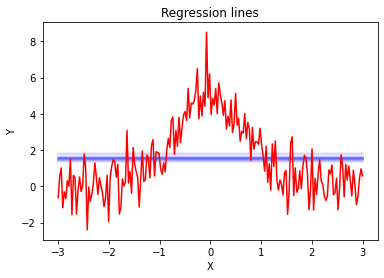

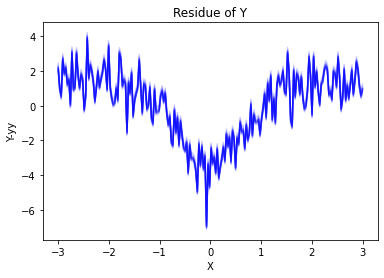

In [77]:
def get_divert_params(params):
    #get_sample_params["divertgent__"]にdivertしたかどうかのフラグが入っている
    #ただしこれはwarmupも含めた結果なので、warmup分をさっ引いて拾ってくる
    #chain毎に存在するものは後が楽になるように結合しておく
    divert=np.array([chain["divergent__"][fit.sim["warmup"]:] for chain in  fit.get_sampler_params()  ]).transpose().reshape(-1)
    didx=np.nonzero(divert)[0]
    #サンプルを取得するがpermutedをFalseにして、シャッフルされる前のデータを取ってくる
    #そうしないと、上のdivert情報と一致しない。
    p=fit.extract(params,permuted=False)
    ret={}
    #divertな要素のみを切りだす(didx)
    for pi in params:
        yy=p[pi]
        yy=yy.reshape( (-1, *yy.shape[2::] ))[didx]
        ret[pi]=yy
    return ret

plot_rec(X,Y,get_divert_params(["yy"]))


# TreeDepthごとに可視化
tree_depthによって大差ないようにみえるが、max(=10)のときだけ、フィット出来てない率が高い事が見て取れる

tree-depth 0
NO-DATA
tree-depth 1


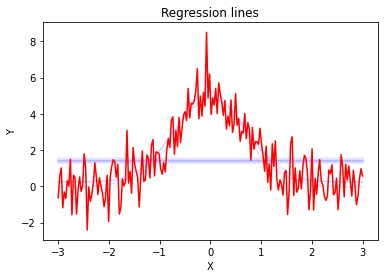

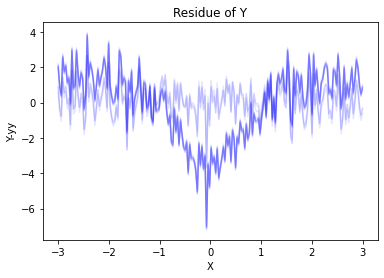

tree-depth 2


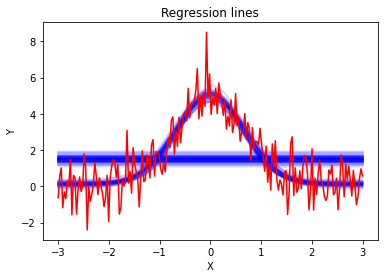

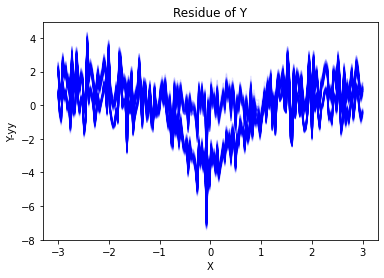

tree-depth 3


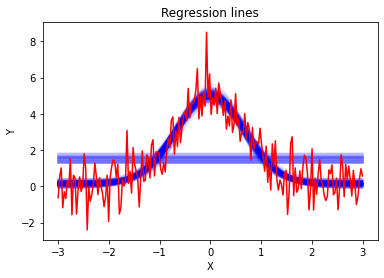

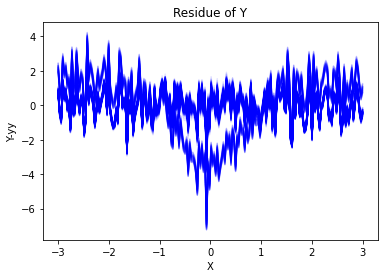

tree-depth 4


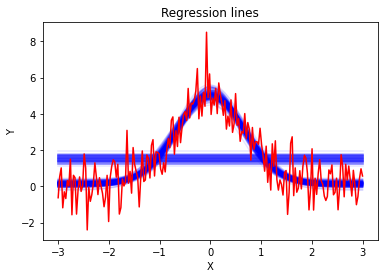

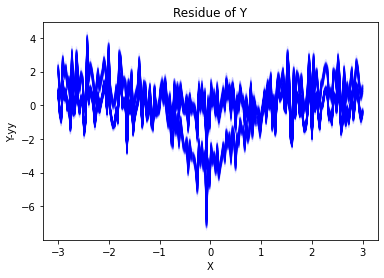

tree-depth 5


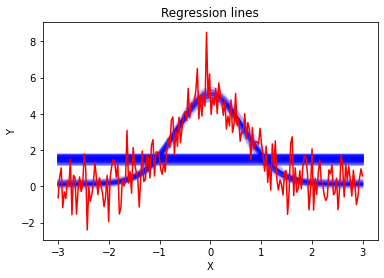

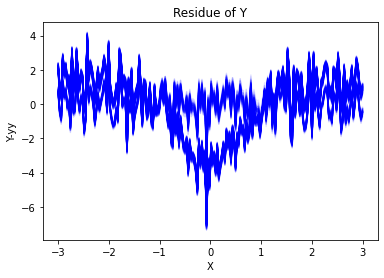

tree-depth 6


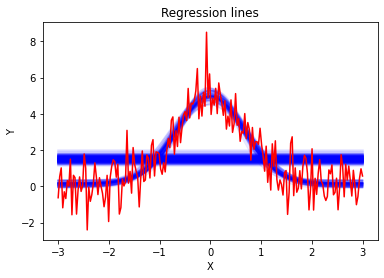

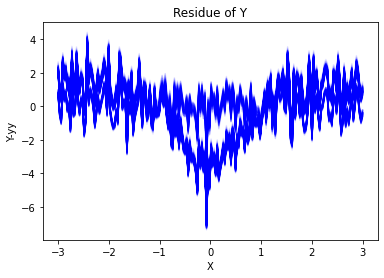

tree-depth 7


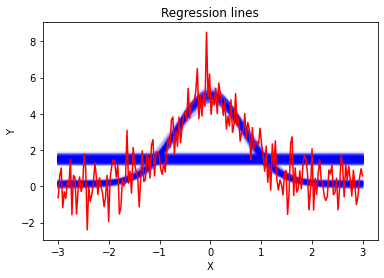

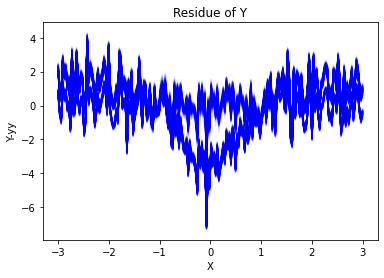

tree-depth 8


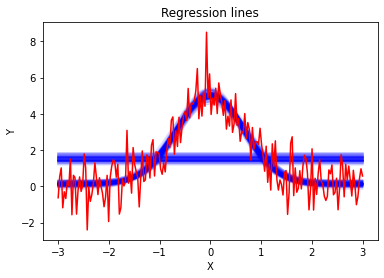

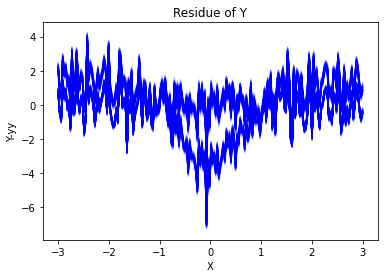

tree-depth 9


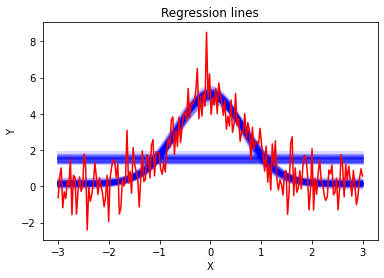

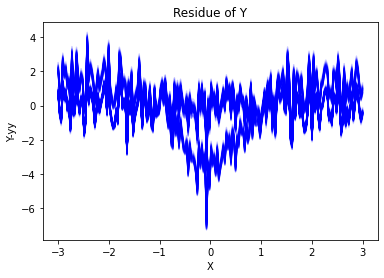

tree-depth 10


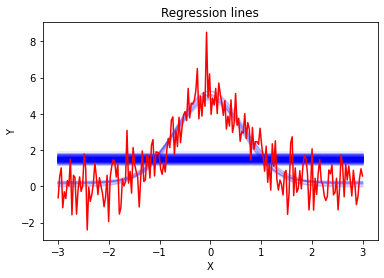

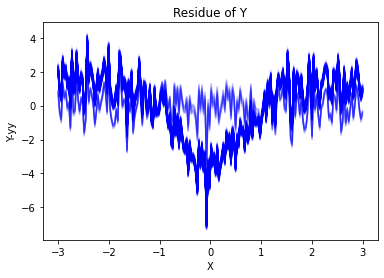

In [80]:
def get_params_at_treedepth(params,depth):
    #get_sample_params["treedepth__"]にNUTS探索時のdepthが入ってる
    d=np.array([chain["treedepth__"][fit.sim["warmup"]:] for chain in  fit.get_sampler_params()  ]).transpose().reshape(-1)
    didx=np.nonzero(d==depth)[0]
    p=fit.extract(params,permuted=False)
    ret={}
    for pi in params:
        yy=p[pi]
        yy=yy.reshape( (-1, *yy.shape[2::] ))[didx]
        ret[pi]=yy
    return ret

for i in range(11):
    print("tree-depth",i)
    plot_rec(X,Y,get_params_at_treedepth(["yy"],i))
 



# 以前HMCの挙動の説明でつかったとっても裾の重い分布の例
軌道が長い(tree-depthが深い）ものは裾部分にあることが解る。

In [109]:
model=get_stan_model("heavyTale",d)
print_code(model)

#run stan code
fit=model.sampling(data={},warmup=1000,iter=1500,chains=16)



INFO:pystan:COMPILING THE C++ CODE FOR MODEL heavyTale_884f4931116b386536347fc8aa8865a7 NOW.


1 parameters {
2     vector[2] x;
3 }
4 model {
5     target += -pow(square(x[1])+square(x[2]),0.05);
6 }


all


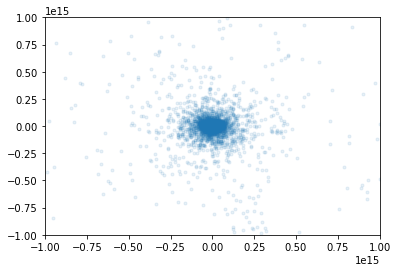

tree-depth 0
(0, 2)


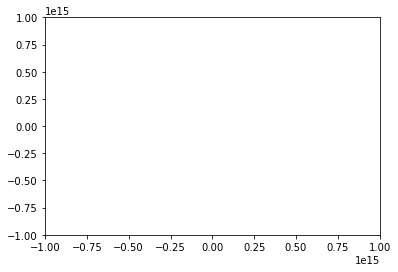

tree-depth 1
(967, 2)


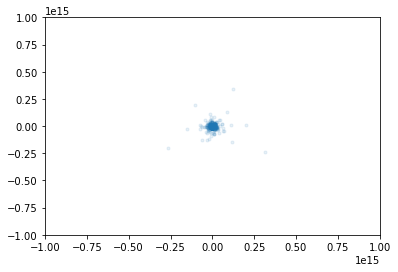

tree-depth 2
(1782, 2)


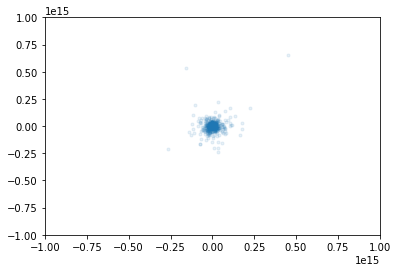

tree-depth 3
(1577, 2)


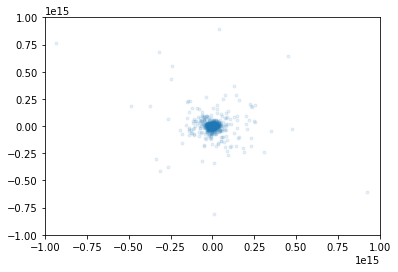

tree-depth 4
(1271, 2)


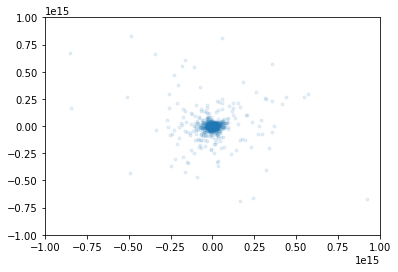

tree-depth 5
(884, 2)


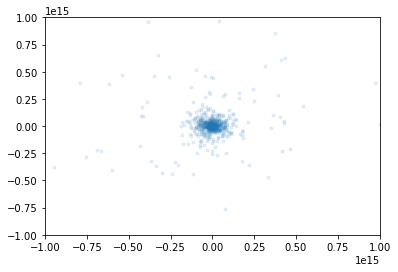

tree-depth 6
(563, 2)


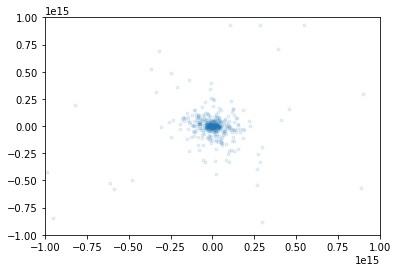

tree-depth 7
(387, 2)


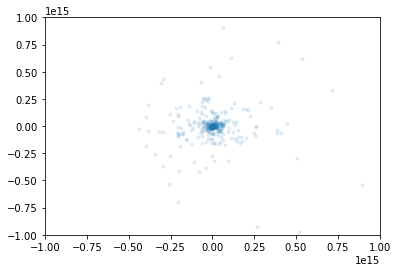

tree-depth 8
(251, 2)


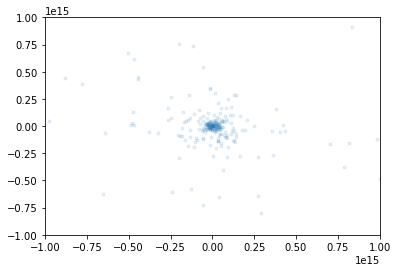

tree-depth 9
(155, 2)


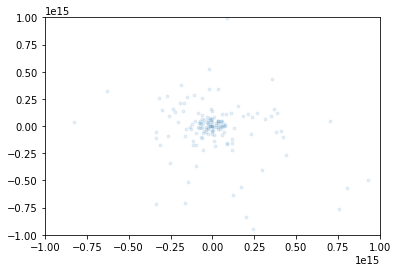

tree-depth 10
(163, 2)


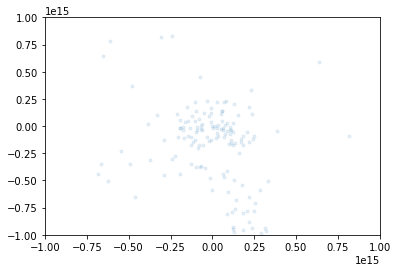

In [118]:
print("all")
rr=1e+15
x=fit.extract(["x"])["x"]
plt.scatter(x[:,0],x[:,1],alpha=0.1,marker=".")
plt.xlim([-rr,rr])
plt.ylim([-rr,rr])
plt.show()


for i in range(11):
    print("tree-depth",i)
    x=get_params_at_treedepth(["x"],i)["x"]
    print(x.shape)
    plt.scatter(x[:,0],x[:,1],alpha=0.1,marker=".")
    plt.xlim([-rr,rr])
    plt.ylim([-rr,rr])
    plt.show()
